In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install konlpy
!pip install keras-rectified-adam

In [69]:
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, Concatenate, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models

from keras_radam import RAdam
from tensorflow.keras.optimizers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Okt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim
import os
import re

import tensorflow.keras as tf

In [49]:
train_df = pd.read_csv('/content/drive/MyDrive/gh/CNNForSentenceClassification/data_in/train_spacing.csv')
test_df = pd.read_csv('/content/drive/MyDrive/gh/CNNForSentenceClassification/data_in/test_spacing.csv')

In [50]:
train_df = train_df.fillna(' ')
test_df = test_df.fillna(' ')

In [51]:
len(test_df)

50000

In [52]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt=Okt()
cl_train =[]

for review in train_df['document']:
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",review)
    word_review = okt.morphs(review_text, stem=True,norm=True)
    word_review = [token for token in word_review if not token in stop_words]
    cl_train.append(' '.join(word_review))

train_df["cl_document"] = cl_train

In [53]:
cl_test =[]
for review in test_df['document']:
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",review)
    word_review = okt.morphs(review_text, stem=True,norm=True)
    word_review = [token for token in word_review if not token in stop_words]
    cl_test.append(' '.join(word_review))

test_df["cl_document"] = cl_test

In [54]:
vocab_size = [] 

for line in train_df['cl_document']:
    vocab_size.extend(str(line).split())
len(set(vocab_size))

39933

In [55]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_df['cl_document'])
word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(train_df['cl_document'])
test_seq = tokenizer.texts_to_sequences(test_df['cl_document'])
train_pad = pad_sequences(train_seq, maxlen=40, padding='pre', truncating='pre')
test_pad = pad_sequences(test_seq, maxlen=40, padding='pre', truncating='pre')

In [56]:
import numpy as np

def load_dic(dic_file) :
  embeddings_index = dict()
  f = open(dic_file)
  for i, line in enumerate(f):
    if i == 0 : continue
    try :
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    except :
      print(i)
      print(values)
  f.close()

  return embeddings_index

embeddings_index = load_dic("/content/drive/MyDrive/gh/CNNForSentenceClassification/embeddings/fasttext.vec")


In [57]:
def gen_embedding_matrix(vocab, embeddings_index, embedding_size) :
  vocabulary_size = len(vocab)+1

  embedding_matrix = np.zeros((vocabulary_size, embedding_size))
  for word, index in vocab.items():
      if index > vocabulary_size - 1:
          break
      else:
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[index] = embedding_vector
  return embedding_matrix

embedding_matrix = gen_embedding_matrix(word_index, embeddings_index, embedding_size=100)
embed_size = embedding_matrix.shape[1]


In [80]:
# set parameters

vocab_size = len(set(word_index))+1
maxlen=40
batch_size = 32
embedding_dims = 100
epochs = 10
VALID_SPLIT = 0.1

In [81]:
embedding_layer1 = Embedding(vocab_size,
                            embedding_dims,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=True,
)
embedding_layer2 = Embedding(vocab_size,
                            embedding_dims,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=True,
)
embedding_layer3 = Embedding(vocab_size,
                            embedding_dims,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=True,
)

In [82]:
print('>>> Build model >>>')

# https://keras.io/layers/embeddings/
model_a = Sequential()
model_a.add(embedding_layer1)
model_a.add(Conv1D(128, 5, activation='relu'))
model_a.add(MaxPooling1D())

model_b = Sequential()
model_b.add(embedding_layer2)
model_b.add(Conv1D(128, 3, activation='relu'))
model_b.add(MaxPooling1D())

model_c = Sequential()
model_c.add(embedding_layer3)
model_c.add(Conv1D(128, 4, activation='relu'))
model_c.add(MaxPooling1D())


conc = concatenate([model_a.output, model_b.output, model_c.output], axis = 1)
out = Flatten()(conc)
out = Dense(128, activation='relu')(out)
out = Dropout(0.2)(out)
out = Dense(128, activation='relu')(out)
out = Dropout(0.2)(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs = [model_a.input, model_b.input, model_c.input], outputs = out)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RAdam(learning_rate=0.001),
              metrics=['accuracy'])


# Adam
# Nadam
# Radam

>>> Build model >>>
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_12_input (InputLayer) [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_13_input (InputLayer) [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_14_input (InputLayer) [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 40, 100)      3993500     embedding_12_input[0][0]         
________________________________________________________________________

In [83]:
y_test=test_df['label'].astype('int32')

In [84]:
model_name = 'cnn_v3'
DATA_OUT_PATH = "/content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/"
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True)

/content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/cnn_v3 -- Folder already exists 



In [85]:
train_input = [train_pad, train_pad, train_pad]
test_input = [test_pad,test_pad,test_pad]
labels = train_df['label'].astype('int32')


history = model.fit(train_input, 
                    labels, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split = VALID_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
4219/4219 [==============================] - 314s 74ms/step - loss: 0.4310 - accuracy: 0.7932 - val_loss: 0.3604 - val_accuracy: 0.8400

Epoch 00001: val_accuracy improved from -inf to 0.84000, saving model to /content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/cnn_v3/weights.h5


OSError: ignored

In [74]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

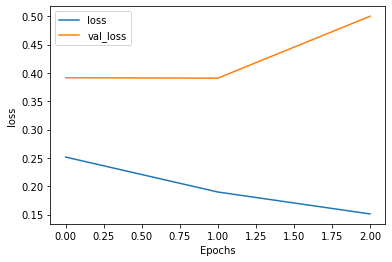

In [75]:
plot_graphs(history, 'loss')

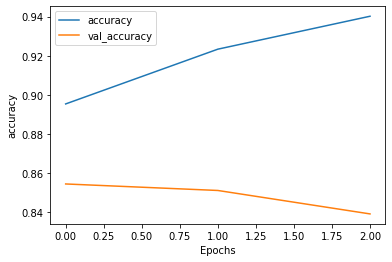

In [76]:
plot_graphs(history, 'accuracy')

In [77]:
DATA_OUT_PATH = "/content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/"
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름

In [78]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [79]:
model.evaluate(test_input, y_test)

1563/1563 [==============================] - 6s 3ms/step - loss: 0.3403 - accuracy: 0.8544


[0.3402796983718872, 0.8544399738311768]